In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg' # For mac users with Retina display

import numpy as np
import os
import matplotlib.pyplot as plt
import cPickle as pickle
import gzip
from photutils import CircularAnnulus
from photutils import CircularAperture
from photutils import aperture_photometry
from astropy.visualization import hist
from stackocat import QSOcat
from read_cats import GetSDSSCat
from astropy import constants as const
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy import units as u

from utils import *

In [2]:
# Cutouts (half-)size in pixels
npix    = {100:49, # PACS pixels are ~ 3  arcsec -> cutouts are 5'
           160:37,  # PACS pixels are ~ 4  arcsec -> cutouts are 5'
           250:25,  # SPIRE pixels are ~ 6  arcsec -> cutouts are 5'
           350:19,  # SPIRE pixels are ~ 8  arcsec -> cutouts are 5'
           500:13}  # SPIRE pixels are ~ 12 arcsec -> cutouts are 5'

# Beam @ different freq
psf     = {100:11.4, # in arcsec
           160:13.7, # in arcsec
           250:17.8, # in arcsec
           350:24.0, # in arcsec
           500:35.2} # in arcsec

factor  = {100:1., 		   # Jy/pixel
           160:1,  		   # Jy/pixel
           250:469./36.,   # Jy/beam -> Jy/pixel
           350:831./64.,   # Jy/beam -> Jy/pixel
           500:1804./144.} # Jy/beam -> Jy/pixel

# Pixel resolution
reso    = {100:3.,  # in arcsec
           160:4.,  # in arcsec
           250:6.,  # in arcsec
           350:8.,  # in arcsec
           500:12.} # in arcsec

positions = {100: (49.5,49.5),
             160: (37.5,37.5),
             250: (25.5,25.5), 
             350: (19.5,19.5), 
             500: (13.5,13.5)}

# H-ATLAS patches
patches = ['G9', 'G12', 'G15']#, 'NGP', 'SGP']

In [3]:
qso_cat_bins = QSOcat(GetSDSSCat(cats=['DR7', 'DR12'], discard_FIRST=True, z_DR12='Z_PIPE'), zbins = [(1.,2.15), (2.15,2.50), (2.50,5.0)], W4only=True, SN_W4=2)


	...z-bin : 1.0 < z < 2.15
	...z-bin : 2.15 < z < 2.5
	...z-bin : 2.5 < z < 5.0


## JGN: check $S_{W4}/S_r$ ratio

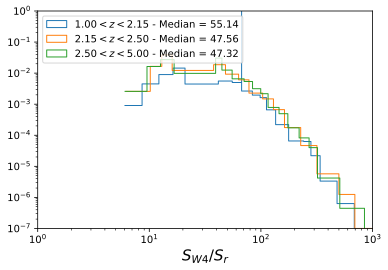

In [4]:
for i in xrange(len(qso_cat_bins.zbins)):
    flag = qso_cat_bins.cat[i]['PSFFLUX_R'] > 0.
    ratio = WISEMag2mJy(qso_cat_bins.cat[i].W4MAG[flag],'W4')/SDSSMag2mJy(qso_cat_bins.cat[i].PSFFLUX_R[flag]-qso_cat_bins.cat[i].EXTINCTION_R[flag])
    hist(ratio, 'blocks', histtype='step',normed=1,label=r'$%.2f < z < %.2f$ - Median = %.2f'%(qso_cat_bins.zbins[i][0],qso_cat_bins.zbins[i][1],np.median(ratio)))
plt.xlim([1,1000])
plt.ylim([1e-7,1])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$S_{W4}/S_r$', size=15)
plt.legend(loc='upper left')
plt.savefig('W4band_rband_ratio_W4_selected.pdf', bboxes_inches='tight')

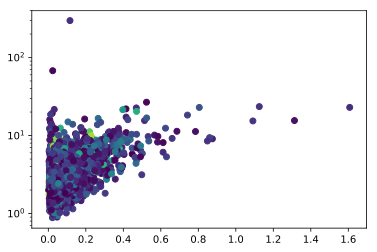

In [5]:
# plt.hexbin(SDSSMag2mJy(qso_cat_bins.cat[2].PSFFLUX_R[flag]-qso_cat_bins.cat[2].EXTINCTION_R[flag]), np.log10(WISEMag2mJy(qso_cat_bins.cat[2].W4MAG[flag],'W4')),bins='log')
plt.scatter(SDSSMag2mJy(qso_cat_bins.cat[2].PSFFLUX_R[flag]-qso_cat_bins.cat[2].EXTINCTION_R[flag]),WISEMag2mJy(qso_cat_bins.cat[2].W4MAG[flag],'W4'), c=qso_cat_bins.cat[2].Z[flag])
# plt.xscale('log')
plt.yscale('log')
# plt.colorbar()

In [6]:
F = {}
for i in xrange(len(qso_cat_bins.zbins)):
    F[i] = qso_cat_bins.cat[i]['PSFFLUX_R'] > 0.
    print len(F[i])

13285
8277
8141


In [7]:
sdss = np.concatenate([SDSSMag2mJy(qso_cat_bins.cat[i].PSFFLUX_R[F[i]]-qso_cat_bins.cat[i].EXTINCTION_R[F[i]]) for i in xrange(3)])

In [8]:
wise = np.concatenate([WISEMag2mJy(qso_cat_bins.cat[i].W4MAG[F[i]],'W4')for i in xrange(3)])

In [9]:
from getdist import plots, MCSamples
import getdist, IPython


In [10]:
names = ["S_r", "S_{W4}"] #["x%s"%i for i in range(ndim)]
labels =  ["\log_{10}S_r\, [mJy]", "\log_{10}S_{W4}\, [mJy]"]# ["x_%s"%i for i in range(ndim)]
samples1 = MCSamples(samples=np.asarray([np.log10(SDSSMag2mJy(qso_cat_bins.cat[0].PSFFLUX_R[F[0]]-qso_cat_bins.cat[0].EXTINCTION_R[F[0]])),np.log10(WISEMag2mJy(qso_cat_bins.cat[0].W4MAG[F[0]],'W4'))]).T ,names = names, labels = labels,)# label=r'$1<z<2.15$')
samples2 = MCSamples(samples=np.asarray([np.log10(SDSSMag2mJy(qso_cat_bins.cat[1].PSFFLUX_R[F[1]]-qso_cat_bins.cat[1].EXTINCTION_R[F[1]])),np.log10(WISEMag2mJy(qso_cat_bins.cat[1].W4MAG[F[1]],'W4'))]).T ,names = names, labels = labels,)# label=r'$2.15<z<2.5$')
samples3 = MCSamples(samples=np.asarray([np.log10(SDSSMag2mJy(qso_cat_bins.cat[2].PSFFLUX_R[F[2]]-qso_cat_bins.cat[2].EXTINCTION_R[F[2]])),np.log10(WISEMag2mJy(qso_cat_bins.cat[2].W4MAG[F[2]],'W4'))]).T ,names = names, labels = labels,)# label=r'$2.5<z<5$')



/Users/fbianchini/.local/lib/python2.7/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'color'
  s)


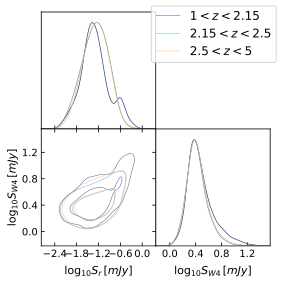

In [11]:
g = plots.getSubplotPlotter()
g.triangle_plot([samples1, samples2, samples3], filled=0, 
                legend_labels=[r'$1<z<2.15$',r'$2.15<z<2.5$', r'$2.5<z<5$'],
               contour_colors=['#1E3888','#47A8BD','#FFAD69'])
plt.savefig('W4band_rband_contours_W4_selected.pdf')

In [186]:
def do_thumbnails_plot(anal, remove_mean=True, remove_max=0, interpolation='bicubic', cmap='bone', fname=None):
    fig = plt.figure(figsize=(10,10))
    i=1
    plt.suptitle(r'H-ATLAS 5 arcmin x 5 arcmin [mJy/pixel]')
    for lambda_ in anal.lambdas:
        for zbin, zbin_edg in enumerate(anal.zbins):
            ax = fig.add_subplot(5, 3, i)
            if i < 4:
                plt.title(r'$%.2f < z < %.2f$' %(zbin_edg[0],zbin_edg[1]), size=15)
#                 print zbin_edg
            simuls = {}
            noises = {}
            for patch in anal.patches:
                simuls[patch] = anal.cuts[lambda_][patch][zbin].copy()
                try:
                    noises[patch] = anal.noise[lambda_][patch][zbin].copy()
                except:
                    pass

            if remove_max > 0:
                for patch in anal.patches:
                    for _ in xrange(remove_max):
                        killme = np.argmax(np.mean(simuls[patch], axis=(1,2)))
                        simuls[patch] = np.delete(simuls[patch], killme, axis=0)
                        try:
                            noises[patch] = np.delete(noises[patch], killme, axis=0)
                        except:
                            pass

            if remove_mean:
                for patch in anal.patches:
                    simuls[patch] -= anal.bkd[lambda_][patch][zbin].mean()
                    # simuls[patch] = np.asarray([simuls[patch][i]-simuls[patch][i].mean(0) for i in xrange(simuls[patch].shape[0])])


            data = np.concatenate([simuls[patch].copy() for patch in anal.patches], axis=0).mean(0)

            # Stuff for inverse variance weighting
            # data = np.concatenate([simuls[patch].copy()/noises[patch].copy()**2 for patch in self.patches], axis=0)#
            # nois = np.concatenate([1/noises[patch].copy()**2 for patch in self.patches], axis=0)#
            # data = data.mean(0)/nois.mean(0)

            # Stuff for variance weighting
            # data = np.concatenate([simuls[patch].copy()*noises[patch].copy() for patch in self.patches], axis=0)
            # nois = np.concatenate([noises[patch].copy() for patch in self.patches], axis=0)
            # data = data.mean(0)/nois.mean(0)

            # plt.imshow(data/data1-1., vmin=-10, vmax=10)
            # plt.colorbar()
            # plt.show()

            # plt.subplot(131)
            # plt.imshow(nois.mean(0), interpolation='bicubic'); plt.colorbar()
            # plt.subplot(132)
            # plt.imshow(data, interpolation='bicubic'); plt.colorbar()
            # plt.subplot(133)
            # plt.imshow(data1, interpolation='bicubic'); plt.colorbar()
            # plt.show()


            # Jy/beam -> mJy/beam
            data /= 1e-3
            
            im = plt.imshow(data,extent=[0,anal.boxsize[lambda_],0,anal.boxsize[lambda_]], interpolation=interpolation, cmap=cmap)
            if i == 1 or i == 4 or i == 7 or i == 10 or i == 13:
                plt.ylabel( r' $\lambda= $ ' +str(lambda_) + r'$\mu m$', size=15)

            # To show PSF
            circin = plt.Circle((40/reso[lambda_],40/reso[lambda_]), radius=psf[lambda_]/reso[lambda_], color='tomato', fill=False)
            ax.add_patch(circin)

            # Ticks stuff
            ax.tick_params(axis='both', direction='in')
            ax.minorticks_on()
            ax.tick_params(axis='both', direction='in', which='minor', bottom='on', top='on', left='on', right='on')
            plt.colorbar()
#             plt.plot(positions[lambda_], 'w+', mew=2

            # Remove tick lables
            labels = [item.get_text() for item in ax.get_xticklabels()]

            empty_string_labels = ['']*len(labels)
            ax.set_xticklabels(empty_string_labels)
            ax.set_yticklabels(empty_string_labels)

            i += 1
            
    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    
    if fname is not None:
        plt.savefig(fname)
    plt.show()
    


In [12]:
qso_cat_100 = QSOcat(GetSDSSCat(cats=['DR7', 'DR12'], discard_FIRST=True, z_DR12='Z_PIPE'), zbins=[(1.,2.15), (2.15,2.50), (2.50,5.0)], W4only=True, SN_W4=2, W4_over_r=100)
qso_cat_100 = QSOcat(GetSDSSCat(cats=['DR7', 'DR12'], discard_FIRST=True, z_DR12='Z_PIPE'), zbins=[(2.5,5.0)], W4only=True, SN_W4=2, W4_over_r=100)


	...z-bin : 1.0 < z < 2.15
	...z-bin : 2.15 < z < 2.5
	...z-bin : 2.5 < z < 5.0
	...z-bin : 2.5 < z < 5.0


In [3]:
qso_cat_500 = QSOcat(GetSDSSCat(cats=['DR7', 'DR12'], discard_FIRST=True, z_DR12='Z_PIPE'), zbins=[(1.,2.15), (2.15,2.50), (2.50,5.0)], W4only=True, SN_W4=2, W4_over_r=500)


	...z-bin : 1.0 < z < 2.15
	...z-bin : 2.15 < z < 2.5
	...z-bin : 2.5 < z < 5.0


In [264]:
hatlas_100 = CutoutAnalysis('result_H-ATLAS_PACS_SPIRE_W4_SNR2_W4_over_r_100/', zbins=[(1.,5.)], lambdas=[100,160,250,350,500])
# hatlas_100 = CutoutAnalysis('result_H-ATLAS_PACS_SPIRE_W4_SNR2_W4_over_r_100/', zbins=[(1.,2.15), (2.15,2.50), (2.50,5.0)], lambdas=[100,160,250,350,500])
# hatlas_500 = CutoutAnalysis('result_H-ATLAS_PACS_SPIRE_W4_SNR2_W4_over_r_500/', zbins=[(1.,2.15), (2.15,2.50), (2.50,5.0)], lambdas=[100,160,250,350,500])


KeyError: 100

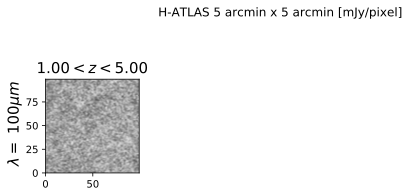

In [265]:
do_thumbnails_plot(hatlas_100, remove_max=2, cmap='Greys',)# fname='/Users/fbianchini/Research/StacktSZ/H-ATLAS_stamps_paper_Greys.pdf')

TypeError: Image data cannot be converted to float

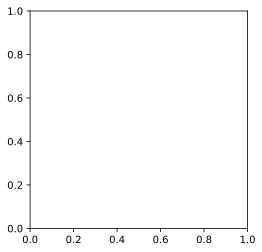

In [266]:
plt.imshow(np.asarray(hatlas_100.bkd[100]['G12']))

In [267]:
len(np.concatenate([hatlas_100.cuts[100][patch][0] for patch in patches]))

101

# W4/r > 100

In [275]:
errs = [ hatlas_100.GetTotBootstrapErrsFit2D(500,0, remove_max=1, nsim=200) for i in xrange(10) ]

In [277]:
np.median(errs)

1.3258395435246328

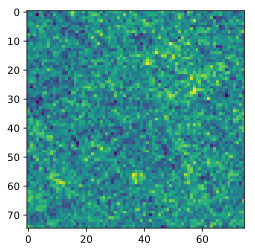

In [270]:
plt.imshow(np.asarray(np.concatenate([hatlas_100.cuts[160][patch][0] for patch in hatlas_100.patches])).mean(0))


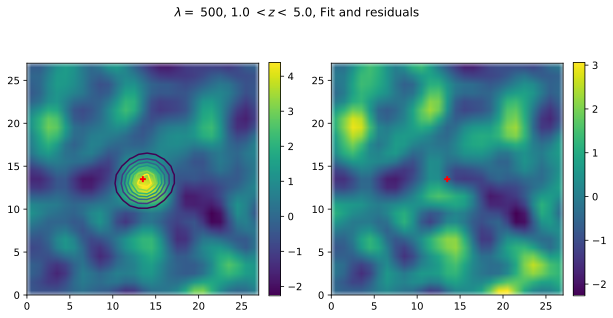

In [234]:
p = hatlas_100.GaussFitTot(500,0,plot=1, remove_max=1)

In [236]:
p.amplitude

Parameter('amplitude', value=4.87843762106)

utils.py:47: RuntimeWarning: overflow encountered in double_scalars
  return 309.540 * 10**(-mags/2.5) * 1e3
utils.py:49: RuntimeWarning: overflow encountered in double_scalars
  return 171.787 * 10**(-mags/2.5) * 1e3
utils.py:51: RuntimeWarning: overflow encountered in double_scalars
  return 31.674 * 10**(-mags/2.5) * 1e3


W1 2974
W2 2974
W3 2974
W4 2974
uk 1589
uk 1582
uk 1592
uk 1597
sdss u 6171
sdss g 6171
sdss r 6171
sdss i 6171
sdss z 6171
100 2.32127165195 1.06947700571
160 0.802636826237 1.8276028281
250 4.78311813112 2.04220475342
350 7.34413658647 1.63796812224
500 4.87843762106 1.36412718232


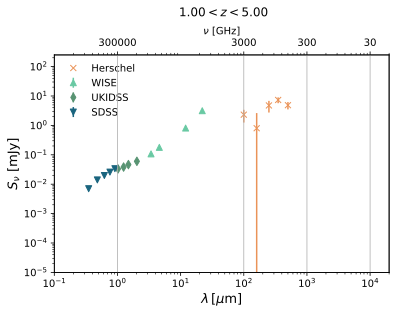

In [285]:
qso_cat_100.PlotFromAnal(0,herschel=hatlas_100)#, akari=akari_bin1, planck=PLANCK_bin1)
# plt.errorbar(a[:,0],a[:,1],yerr=[a[:,2],a[:,3]], fmt='x', ms=3, label=r'All W4 selected')
plt.legend(loc='lower left')
plt.ylim([1e-5,250]) 
plt.grid()
plt.savefig('SEDs_W4_selected_W4_over_r_100_zbin_1_5.pdf',)
# plt.savefig('SEDs_W4_selected_W4_over_r_100_zbin_1_2.15.pdf',)

In [283]:
qso_cat_100.WriteToFileFromAnal(0, herschel=hatlas_100, filename='SDSS_QSOs_W4_selected_W4_over_r_100_stacked_fluxes_SPIRE_PACS_WISE_UKIDSS_SDSS')

100 2.19248043541
160 -0.0441785104748
250 5.40446204291
350 7.01820017517
500 5.66222661452


100 0.486321905933 1.75094545688
160 -0.600343694752 2.63154558325
250 5.00759751784 5.69510515087
350 6.07759119816 27.9022245416
500 4.89401024081 61.6617512247


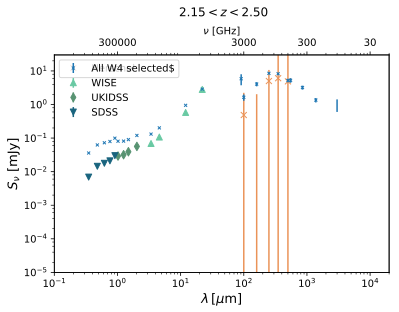

In [24]:
qso_cat_100.PlotFromAnal(1,herschel=hatlas_100)#, akari=akari_bin1, planck=PLANCK_bin1)
plt.errorbar(b[:,0],b[:,1],yerr=[b[:,2],b[:,3]], fmt='x', ms=3, label=r'All W4 selected$')
plt.ylim([1e-5,3e1]) 
plt.legend(loc='upper left')
plt.ylim([1e-5,3e1]) 
plt.savefig('SEDs_W4_selected_W4_over_r_100_zbin_2.15_2.5.pdf',)

100 3.61013683538 1.56505583465
160 1.77080693696 2.50421810798
250 6.09650230398 302.301353109
350 8.0978347639 4.05147724412
500 6.76942440113 2640.06411874


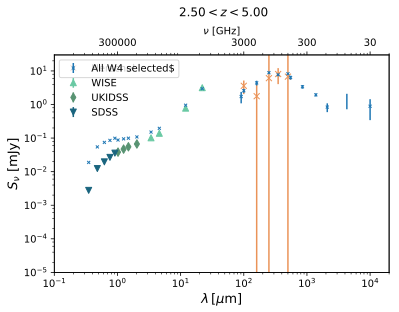

In [23]:
qso_cat_100.PlotFromAnal(2,herschel=hatlas_100)#, akari=akari_bin1, planck=PLANCK_bin1)
plt.errorbar(c[:,0],c[:,1],yerr=[c[:,2],c[:,3]], fmt='x', ms=3, label=r'All W4 selected$')
plt.ylim([1e-5,3e1]) 
plt.legend(loc='upper left')
plt.ylim([1e-5,3e1]) 
plt.savefig('SEDs_W4_selected_W4_over_r_100_zbin_2.5_5.pdf',)

In [5]:
a = np.loadtxt('SDSS_QSOs_W4selected_SNR2_stacked_fluxes_SPIRE_PACS_WISE_UKIDSS_SDSS_AKARI_PLANCK_CIBsub_2_zbin_1.0_2.15.dat')
b = np.loadtxt('SDSS_QSOs_W4selected_SNR2_stacked_fluxes_SPIRE_PACS_WISE_UKIDSS_SDSS_AKARI_PLANCK_CIBsub_2_zbin_2.15_2.5.dat')
c = np.loadtxt('SDSS_QSOs_W4selected_SNR2_stacked_fluxes_SPIRE_PACS_WISE_UKIDSS_SDSS_AKARI_PLANCK_CIBsub_2_zbin_2.5_5.0.dat')


In [39]:
qso_cat_100.err_mean

{0: 0.00015193881091469608,
 1: 0.00011003644369769882,
 2: 0.0001018712365902518,
 'all': 8.9641376390764562e-05}

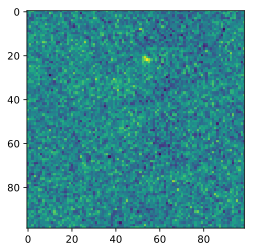

In [47]:
plt.imshow(np.asarray(np.concatenate([hatlas_100.cuts[100][patch][2] for patch in hatlas_100.patches])).mean(0))


W1 30
W2 30
W3 30
W4 30
W1 19
W2 19
W3 19
W4 19
W1 23
W2 23
W3 23
W4 23
uk 20
uk 20
uk 20
uk 20
uk 15
uk 15
uk 13
uk 15
uk 16
uk 16
uk 17
uk 18
sdss u 65
sdss g 65
sdss r 65
sdss i 65
sdss z 65
sdss u 41
sdss g 41
sdss r 41
sdss i 41
sdss z 41
sdss u 50
sdss g 50
sdss r 50
sdss i 50
sdss z 50


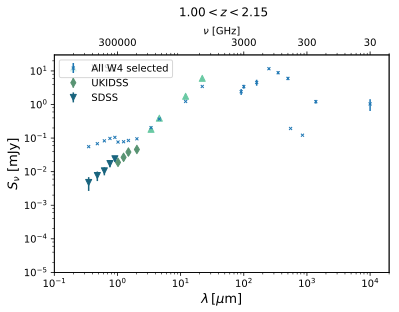

In [76]:
qso_cat_500.PlotFromAnal(0)#,herschel=hatlas_100)#, akari=akari_bin1, planck=PLANCK_bin1)
plt.errorbar(a[:,0],a[:,1],yerr=[a[:,2],a[:,3]], fmt='x', ms=3, label=r'All W4 selected')
plt.legend(loc='upper left')
plt.ylim([1e-5,3e1]) 
plt.savefig('SEDs_W4_selected_W4_over_r_500_zbin_1_2.15.pdf',)

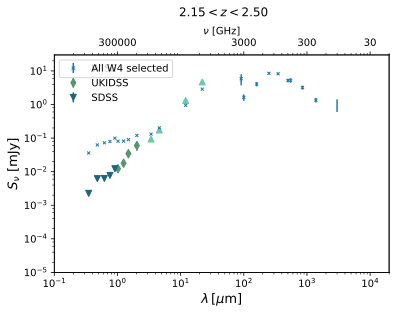

In [77]:
qso_cat_500.PlotFromAnal(1)#,herschel=hatlas_100)#, akari=akari_bin1, planck=PLANCK_bin1)
plt.errorbar(b[:,0],b[:,1],yerr=[b[:,2],b[:,3]], fmt='x', ms=3, label=r'All W4 selected')
plt.ylim([1e-5,3e1]) 
plt.legend(loc='upper left')
plt.ylim([1e-5,3e1]) 
plt.savefig('SEDs_W4_selected_W4_over_r_500_zbin_2.15_2.5.pdf',)

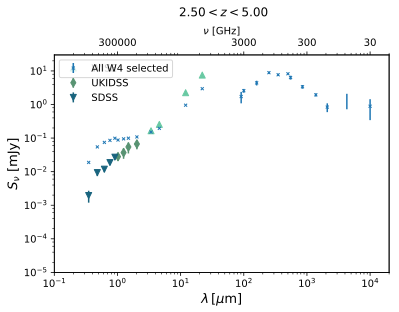

In [78]:
qso_cat_500.PlotFromAnal(2)#,herschel=hatlas_100)#, akari=akari_bin1, planck=PLANCK_bin1)
plt.errorbar(c[:,0],c[:,1],yerr=[c[:,2],c[:,3]], fmt='x', ms=3, label=r'All W4 selected')
plt.ylim([1e-5,3e1]) 
plt.legend(loc='upper left')
plt.ylim([1e-5,3e1]) 
plt.savefig('SEDs_W4_selected_W4_over_r_500_zbin_2.5_5.pdf',)

In [18]:
lam = 100
for patch in hatlas_500.patches:
    for i in xrange(3):
        print patch, i, len(hatlas_500.cuts[lam][patch][i])
# a = np.concatenate([[hatlas_500.cuts[lam][patch][zbin] for patch in hatlas_500.patches] for zbin in xrange(3)])





G9 0 0
G9 1 0
G9 2 1
G12 0 0
G12 1 0
G12 2 0
G15 0 0
G15 1 0
G15 2 1


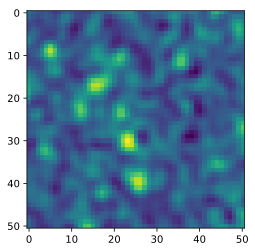

In [22]:
plt.imshow(hatlas_500.cuts[250]['G9'][2][0])

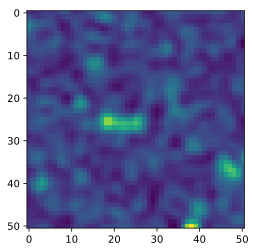

In [23]:
plt.imshow(hatlas_500.cuts[250]['G15'][2][0])

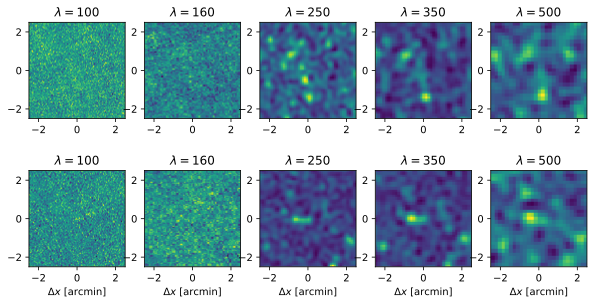

In [35]:
plt.figure(figsize=(10,5))
for i, lam in enumerate(hatlas_500.lambdas):
    plt.subplot(2,5,i+1)
    plt.title(r'$\lambda=%d$'%lam)
    plt.imshow(hatlas_500.cuts[lam]['G9'][2][0], extent=[-2.5,2.5,-2.5,2.5])
    plt.subplot(2,5,i+6)
    plt.title(r'$\lambda=%d$'%lam)
    plt.imshow(hatlas_500.cuts[lam]['G15'][2][0], extent=[-2.5,2.5,-2.5,2.5])
    plt.xlabel(r'$\Delta x$ [arcmin]')
    
plt.savefig('W4_over_r_500_HATLAS.pdf')

In [52]:
hatlas_500.extras[250]['G9'][2]['Z'][0]

2.594158411026001

In [44]:
qso1 = qso_cat_500.cat[2].loc[np.isclose(qso_cat_500.cat[2].Z, 2.81443667)]

In [49]:
print qso1.RA
print qso1.DEC

227626    222.806748
Name: RA, dtype: float64
227626    1.542819
Name: DEC, dtype: float64


In [53]:
qso2 = qso_cat_500.cat[2].loc[np.isclose(qso_cat_500.cat[2].Z, 2.594158411026001)]

In [54]:
print qso2.RA
print qso2.DEC

59396    128.702005
Name: RA, dtype: float64
59396    1.989214
Name: DEC, dtype: float64


In [56]:
import healpy as hp

In [57]:
mask = hp.read_map('/Users/fbianchini/Research/Data/herschel_contrast_zcut_1.5_10_ALL_gal_512.fits')
mask[mask > -2] = 1

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


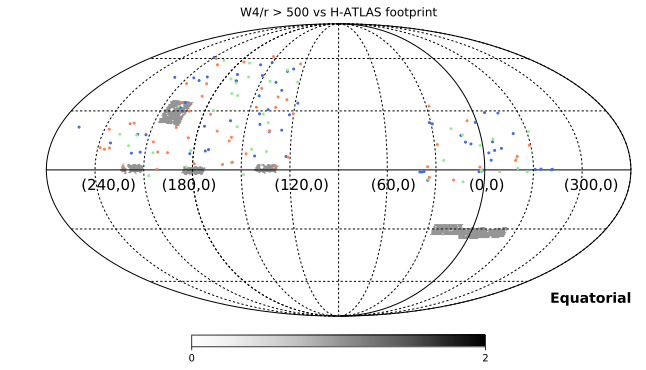

In [91]:
hp.mollview(mask, title="W4/r > 500 vs H-ATLAS footprint", cmap='Greys', coord='GC', rot=90)
hp.graticule()    # add grid
hp.projplot(qso_cat_500.cat[0].RA.values, qso_cat_500.cat[0].DEC.values, lonlat=True, color='royalblue', ls='None', marker='o', ms=2)#, coord='G')
hp.projplot(qso_cat_500.cat[1].RA.values, qso_cat_500.cat[1].DEC.values, lonlat=True, color='lightgreen', ls='None', marker='o', ms=2)#, coord='G')
hp.projplot(qso_cat_500.cat[2].RA.values, qso_cat_500.cat[2].DEC.values, lonlat=True, color='coral', ls='None', marker='o', ms=2)#, coord='G')
hp.projtext(0+9,-10,'(0,0)',fontsize=15, coord=['C'],lonlat=True)
hp.projtext(60+10,-10,'(60,0)',fontsize=15, coord=['C'],lonlat=True)
hp.projtext(120+10,-10,'(120,0)',fontsize=15, coord=['C'],lonlat=True)
hp.projtext(180+20,-10,'(180,0)',fontsize=15, coord=['C'],lonlat=True)
hp.projtext(240+10,-10,'(240,0)',fontsize=15, coord=['C'],lonlat=True)
hp.projtext(300+10,-10,'(300,0)',fontsize=15, coord=['C'],lonlat=True)
plt.savefig('W4_over_r_500_vs_HATLAS_footprint_eq.pdf')

In [92]:
cnt = 0
for i in xrange(3):
    cnt += len(qso_cat_500.cat[i])
print cnt

156


In [94]:
156 * 150./11000

2.1272727272727274

## AL: check W4 selected AGN bolometric luminosity using Netzer+16 formula

In [12]:
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import Planck15 as cosmo

In [198]:
def GetLbol5100(cat, lam_rf=5100):
    L_bol = []
    nu_rf = const.c.to('angstrom/s').value/lam_rf
    lambdas = np.asarray([22, 12, 4.6, 3.4, 2.03, 1.49, 1.25, 1.02, 0.91, 0.76, 0.62, 0.48, 0.35]) # micron
    for idz in xrange(len(cat.zbins)):
        for i in xrange(len(cat.cat[idz].Z)):
            nu_obs = nu_rf / (1+cat.cat[idz].Z.values[i])
            lam_obs = lam_rf * 0.0001 * (1+cat.cat[idz].Z.values[i]) # micron
#             print lam_obs
            fluxes = np.asarray([
                                WISEMag2mJy(cat.cat[idz].W4MAG.values[i],'W4'),
                                WISEMag2mJy(cat.cat[idz].W3MAG.values[i],'W3'),
                                WISEMag2mJy(cat.cat[idz].W2MAG.values[i],'W2'),
                                WISEMag2mJy(cat.cat[idz].W1MAG.values[i],'W1'),
                                cat.cat[idz].KFLUX.values[i] * WmHz2mJy,
                                cat.cat[idz].HFLUX.values[i] * WmHz2mJy,
                                cat.cat[idz].JFLUX.values[i] * WmHz2mJy,
                                cat.cat[idz].YFLUX.values[i] * WmHz2mJy,
                                SDSSMag2mJy(cat.cat[idz].PSFFLUX_Z.values[i]-cat.cat[idz].EXTINCTION_Z.values[i]),
                                SDSSMag2mJy(cat.cat[idz].PSFFLUX_I.values[i]-cat.cat[idz].EXTINCTION_I.values[i]),
                                SDSSMag2mJy(cat.cat[idz].PSFFLUX_R.values[i]-cat.cat[idz].EXTINCTION_R.values[i]),
                                SDSSMag2mJy(cat.cat[idz].PSFFLUX_G.values[i]-cat.cat[idz].EXTINCTION_G.values[i]),
                                SDSSMag2mJy(cat.cat[idz].PSFFLUX_U.values[i]-cat.cat[idz].EXTINCTION_U.values[i])
                                ]) # mJy
            sed = np.interp(lam_obs, lambdas, fluxes,)*1e-3 # Jy
#             print sed
            dl = cosmo.luminosity_distance(cat.cat[idz].Z.values[i]).to('cm').value
            L_nu = sed * 1e-23  * (4.*np.pi)*dl**2/(1+cat.cat[idz].Z.values[i]) # erg/s/Hz
            L_bol.append(4*nu_rf*L_nu)
    
    return np.asarray(L_bol)

In [199]:
L_bols5100 = GetLbol5100(qso_cat_bins)

In [200]:
L_bols5100

array([  3.82096395e+45,   3.54125070e+44,   5.94077139e+45, ...,
         6.57261343e+45,   2.71210989e+45,   3.16262031e+45])

In [123]:
import astropy.units as u

In [125]:
5100*u.angstrom.to('micron')

0.5100000000000001

In [176]:
def GetLbol(cat, lam_rf=1350):
    L_bol = []
    nu_rf = const.c.to('angstrom/s').value/lam_rf
    lambdas = np.asarray([22, 12, 4.6, 3.4, 2.03, 1.49, 1.25, 1.02, 0.91, 0.76, 0.62, 0.48, 0.35]) # micron
    for idz in xrange(len(cat.zbins)):
        for i in xrange(len(cat.cat[idz].Z[:])):
            if cat.cat[idz].Z.values[i] < 1.6: continue
            nu_obs = nu_rf / (1+cat.cat[idz].Z.values[i])
            lam_obs = lam_rf * 0.0001 * (1+cat.cat[idz].Z.values[i]) # micron
#             print lam_obs
            fluxes = np.asarray([
                                WISEMag2mJy(cat.cat[idz].W4MAG.values[i],'W4'),
                                WISEMag2mJy(cat.cat[idz].W3MAG.values[i],'W3'),
                                WISEMag2mJy(cat.cat[idz].W2MAG.values[i],'W2'),
                                WISEMag2mJy(cat.cat[idz].W1MAG.values[i],'W1'),
                                cat.cat[idz].KFLUX.values[i] * WmHz2mJy,
                                cat.cat[idz].HFLUX.values[i] * WmHz2mJy,
                                cat.cat[idz].JFLUX.values[i] * WmHz2mJy,
                                cat.cat[idz].YFLUX.values[i] * WmHz2mJy,
                                SDSSMag2mJy(cat.cat[idz].PSFFLUX_Z.values[i]-cat.cat[idz].EXTINCTION_Z.values[i]),
                                SDSSMag2mJy(cat.cat[idz].PSFFLUX_I.values[i]-cat.cat[idz].EXTINCTION_I.values[i]),
                                SDSSMag2mJy(cat.cat[idz].PSFFLUX_R.values[i]-cat.cat[idz].EXTINCTION_R.values[i]),
                                SDSSMag2mJy(cat.cat[idz].PSFFLUX_G.values[i]-cat.cat[idz].EXTINCTION_G.values[i]),
                                SDSSMag2mJy(cat.cat[idz].PSFFLUX_U.values[i]-cat.cat[idz].EXTINCTION_U.values[i])
                                ]) # mJy
            sed = np.interp(lam_obs, lambdas[::-1], fluxes[::-1],) *1e-3# Jy
            dl = cosmo.luminosity_distance(cat.cat[idz].Z.values[i]).to('cm').value
#             print sed
            L_nu = sed * 1e-23 * 4.*np.pi * dl**2 / (1+cat.cat[idz].Z.values[i]) # erg/s/Hz
            L_bol.append(2*nu_rf*L_nu) # erg/s
    
    return np.asarray(L_bol)

In [177]:
L_bols = GetLbol(qso_cat_bins)

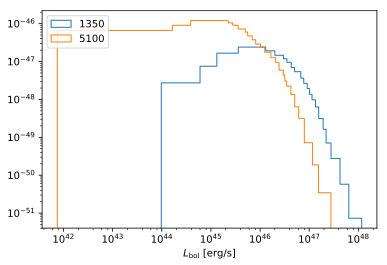

In [206]:
hist(L_bols[L_bols>0], 'blocks', histtype='step', label='1350', normed=1)
hist(L_bols5100[L_bols5100>0], 'blocks', histtype='step', label='5100', normed=1)
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='best')
plt.xlabel(r'$L_{\rm bol}$ [erg/s]')
plt.savefig('L_bol_W4selected_normed.pdf')

In [203]:
len(qso_cat_100.cat[0]) + len(qso_cat_100.cat[1]) + len(qso_cat_100.cat[2])

6171

In [204]:
len(qso_cat_500.cat[0]) + len(qso_cat_500.cat[1]) + len(qso_cat_500.cat[2])

156

## W4-selected cross-match w/ H-ATLAS catalog

In [13]:
hatlas_cat = fits.open('/Users/fbianchini/Downloads/HATLAS_DR1_CATALOGUE_V1.2.FITS')

In [14]:
hatlas_cat[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional table                            
NAXIS1  =                  597 / width of table in bytes                        
NAXIS2  =               120230 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group                                 
TFIELDS =                   80 / number of columns                              
EXTNAME = './HATLAS_DR1_CATALOGUE_V1.2.DAT' / table name                        
TTYPE1  = 'HATLAS_IAU_ID'      / label for column 1                             
TFORM1  = '23A     '           / format for column 1                            
TTYPE2  = 'IDNAME  '           / label for column 2                             
TFORM2  = '14A     '        

In [57]:
len(hatlas_cat[1].data.F250/hatlas_cat[1].data.E250)

120230

In [15]:
qso_cat_W4 = QSOcat(GetSDSSCat(cats=['DR7', 'DR12'], discard_FIRST=True, z_DR12='Z_PIPE'), [(2.5,5)], W4only=True, SN_W4=2)


	...z-bin : 2.5 < z < 5


In [16]:
c_hatlas = SkyCoord(hatlas_cat[1].data.RA*u.degree, hatlas_cat[1].data.DEC*u.degree)#, frame='icrs')

In [17]:
c_sdss = SkyCoord(ra=qso_cat_W4.cat[0].RA*u.degree, dec=qso_cat_W4.cat[0].DEC*u.degree)


In [18]:
idx, d2d, d3d = c_sdss.match_to_catalog_sky(c_hatlas)  

In [19]:
idx_hatlas, d2d_hatlas, d3d_hatlas = c_hatlas.match_to_catalog_sky(c_sdss)  

In [20]:
d2d[d2d <= 2.5*u.arcsec]

<Angle [ 0.0005003 , 0.00018592, 0.00066099, 0.00062027, 0.00033562,
         0.0003834 , 0.00063724, 0.00043209, 0.00039829, 0.0006021 ,
         0.00021515, 0.0004073 , 0.00047918, 0.00046022] deg>

In [21]:
overlap = np.where(d2d <= 2.5*u.arcsec)[0]


In [22]:
len(overlap)

14

In [172]:
overlap_hatlas = np.where(d2d_hatlas <= 2.5*u.arcsec)[0]


In [173]:
myman = qso_cat_W4.cat[0].iloc[overlap,:]

In [174]:
myman.W4SNR

58990      4.1
63655      2.2
64633      3.1
66377      3.8
66481      4.3
66773      2.6
67545      3.5
70696      2.3
73372      5.3
73742     18.5
74217      2.7
76105      3.5
76387      2.4
78577      6.5
143749     4.6
152202     2.3
152781     2.1
154926     8.2
158698     2.3
210050     8.1
210271     4.7
210347     4.4
210390     4.7
210929     7.7
212836     6.5
213087    10.9
213105    12.6
215917     4.6
216567     7.8
217010     4.2
217362     2.1
219551     8.6
220378     3.1
223238     4.6
225645     7.8
227626    12.9
Name: W4SNR, dtype: float64

In [176]:
uflux = np.mean(SDSSMag2mJy(myman.PSFFLUX_U - myman.EXTINCTION_U))
gflux = np.mean(SDSSMag2mJy(myman.PSFFLUX_G - myman.EXTINCTION_G))
rflux = np.mean(SDSSMag2mJy(myman.PSFFLUX_R - myman.EXTINCTION_R))
iflux = np.mean(SDSSMag2mJy(myman.PSFFLUX_I - myman.EXTINCTION_I))
zflux = np.mean(SDSSMag2mJy(myman.PSFFLUX_Z - myman.EXTINCTION_Z))

erruflux = np.std(SDSSMag2mJy(myman.PSFFLUX_U - myman.EXTINCTION_U))/np.sqrt(len(myman.PSFFLUX_U))
errgflux = np.std(SDSSMag2mJy(myman.PSFFLUX_G - myman.EXTINCTION_G))/np.sqrt(len(myman.PSFFLUX_G))
errrflux = np.std(SDSSMag2mJy(myman.PSFFLUX_R - myman.EXTINCTION_R))/np.sqrt(len(myman.PSFFLUX_R))
erriflux = np.std(SDSSMag2mJy(myman.PSFFLUX_I - myman.EXTINCTION_I))/np.sqrt(len(myman.PSFFLUX_I))
errzflux = np.std(SDSSMag2mJy(myman.PSFFLUX_Z - myman.EXTINCTION_Z))/np.sqrt(len(myman.PSFFLUX_Z))



In [177]:
W1 = np.mean(WISEMag2mJy(myman.W1MAG, W='W1'))
W2 = np.mean(WISEMag2mJy(myman.W2MAG, W='W2'))
W3 = np.mean(WISEMag2mJy(myman.W3MAG, W='W3'))
W4 = np.mean(WISEMag2mJy(myman.W4MAG, W='W4'))

errW1 = np.std(WISEMag2mJy(myman.W1MAG, W='W1')) / np.sqrt(len(myman.W1MAG))
errW2 = np.std(WISEMag2mJy(myman.W2MAG, W='W2')) / np.sqrt(len(myman.W2MAG))
errW3 = np.std(WISEMag2mJy(myman.W3MAG, W='W3')) / np.sqrt(len(myman.W3MAG))
errW4 = np.std(WISEMag2mJy(myman.W4MAG, W='W4')) / np.sqrt(len(myman.W4MAG))

In [178]:
y = np.mean(myman.YFLUX[myman.UKIDSS_MATCHED==1] * WmHz2mJy)
j = np.mean(myman.JFLUX[myman.UKIDSS_MATCHED==1] * WmHz2mJy)
h = np.mean(myman.HFLUX[myman.UKIDSS_MATCHED==1] * WmHz2mJy)
k = np.mean(myman.KFLUX[myman.UKIDSS_MATCHED==1] * WmHz2mJy)

erry = np.std(myman.YFLUX[myman.UKIDSS_MATCHED==1] * WmHz2mJy) / np.sqrt(len(myman.YFLUX[myman.UKIDSS_MATCHED==1]))
errj = np.std(myman.JFLUX[myman.UKIDSS_MATCHED==1] * WmHz2mJy) / np.sqrt(len(myman.JFLUX[myman.UKIDSS_MATCHED==1]))
errh = np.std(myman.HFLUX[myman.UKIDSS_MATCHED==1] * WmHz2mJy) / np.sqrt(len(myman.HFLUX[myman.UKIDSS_MATCHED==1]))
errk = np.std(myman.KFLUX[myman.UKIDSS_MATCHED==1] * WmHz2mJy) / np.sqrt(len(myman.KFLUX[myman.UKIDSS_MATCHED==1]))

0.394607843137
0.441176470588


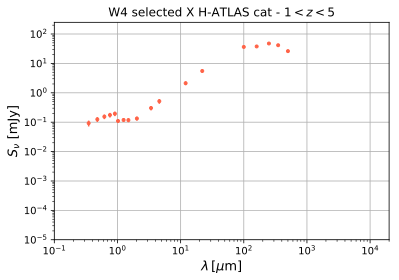

In [181]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.errorbar(3.4, W1, yerr=errW1, fmt='o', color='tomato', ms=3)#, label='SDSS 022052.11+013711.1')
ax1.errorbar(4.6, W2, yerr=errW2, fmt='o', color='tomato', ms=3)
ax1.errorbar(12,  W3, yerr=errW3, fmt='o', color='tomato', ms=3)
ax1.errorbar(22,  W4, yerr=errW4, fmt='o', color='tomato', ms=3)
ax1.errorbar(1.02, y, yerr=erry, fmt='o', color='tomato',ms=3)#, label='UKIDSS')
ax1.errorbar(1.25, j, yerr=errj, fmt='o', color='tomato',ms=3)
ax1.errorbar(1.49, h, yerr=errh, fmt='o', color='tomato',ms=3)
ax1.errorbar(2.03, k, yerr=errk, fmt='o', color='tomato',ms=3)
ax1.errorbar(0.35, uflux, yerr=erruflux, fmt='o', color='tomato',ms=3)#, label='SDSS')
ax1.errorbar(0.48, gflux, yerr=errgflux, fmt='o', color='tomato',ms=3)
ax1.errorbar(0.62, rflux, yerr=errrflux, fmt='o', color='tomato',ms=3)
ax1.errorbar(0.76, iflux, yerr=erriflux, fmt='o', color='tomato',ms=3)
ax1.errorbar(0.91, zflux, yerr=errzflux, fmt='o', color='tomato',ms=3)

ax1.errorbar(100, GetMeanStdPACS(hatlas_cat[1].data.F100BEST[overlap_hatlas]*1000)[0], yerr=errflux100, fmt='o', color='tomato',ms=3)
ax1.errorbar(160, GetMeanStdPACS(hatlas_cat[1].data.F160BEST[overlap_hatlas]*1000)[0], yerr=errflux160, fmt='o', color='tomato',ms=3)
ax1.errorbar(250, flux250, yerr=errflux250, fmt='o', color='tomato',ms=3)
ax1.errorbar(350, flux350, yerr=errflux350, fmt='o', color='tomato',ms=3)
ax1.errorbar(500, flux500, yerr=errflux500, fmt='o', color='tomato',ms=3)

# plt.errorbar(a[:,0],a[:,1],yerr=[a[:,2],a[:,3]], fmt='x', ms=3, label=r'W4 selected $2.5<z<5$')
ax1.set_xlabel(r'$\lambda \, [\mu$m]', size=13)
ax1.set_ylabel(r'$S_{\nu}$ [mJy]', size=13)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(loc='lower left', frameon=0)
ax1.set_ylim([1e-5,2.5e2]) 
# ax1.set_ylim(1e-5) 
ax1.set_xlim([1e-1,2e4]) 
plt.grid()
plt.title(r'W4 selected X H-ATLAS cat - $1 < z < 5$')
# plt.title(r'W4 selected X H-ATLAS cat - No $z$-cut')
plt.savefig('QSO_W4selected_crossmatch_HATLAS_cat_1_z_5_.pdf')

In [180]:
flux100 = np.mean(hatlas_cat[1].data.F100BEST[overlap_hatlas]*1000)
flux160 = np.mean(hatlas_cat[1].data.F160BEST[overlap_hatlas]*1000)
flux250 = np.mean(hatlas_cat[1].data.F250BEST[overlap_hatlas]*1000)
flux350 = np.mean(hatlas_cat[1].data.F350BEST[overlap_hatlas]*1000)
flux500 = np.mean(hatlas_cat[1].data.F500BEST[overlap_hatlas]*1000)

errflux100 = np.std(hatlas_cat[1].data.F100BEST[overlap_hatlas]*1000) / np.sqrt(len(hatlas_cat[1].data.F100BEST[overlap_hatlas]))
errflux160 = np.std(hatlas_cat[1].data.F160BEST[overlap_hatlas]*1000) / np.sqrt(len(hatlas_cat[1].data.F160BEST[overlap_hatlas]))
errflux250 = np.std(hatlas_cat[1].data.F250BEST[overlap_hatlas]*1000) / np.sqrt(len(hatlas_cat[1].data.F250BEST[overlap_hatlas]))
errflux350 = np.std(hatlas_cat[1].data.F350BEST[overlap_hatlas]*1000) / np.sqrt(len(hatlas_cat[1].data.F350BEST[overlap_hatlas]))
errflux500 = np.std(hatlas_cat[1].data.F500BEST[overlap_hatlas]*1000) / np.sqrt(len(hatlas_cat[1].data.F500BEST[overlap_hatlas]))

In [137]:
flux500

26.140643156072045

In [122]:
len(np.where((myman.Z > 1) & (myman.Z <5))[0])

36

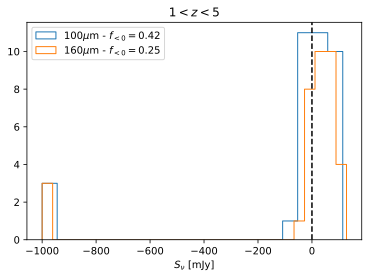

In [35]:
hist(hatlas_cat[1].data.F100BEST[overlap_hatlas]*1000,'knuth',histtype='step',label=r'100$\mu$m - $f_{<0}=%.2f$'%(1.*(len(hatlas_cat[1].data.F100BEST[overlap_hatlas][hatlas_cat[1].data.F100BEST[overlap_hatlas]<0]))/len(hatlas_cat[1].data.F100BEST[overlap_hatlas])))
hist(hatlas_cat[1].data.F160BEST[overlap_hatlas]*1000,'knuth',histtype='step',label=r'160$\mu$m - $f_{<0}=%.2f$'%(1.*(len(hatlas_cat[1].data.F160BEST[overlap_hatlas][hatlas_cat[1].data.F160BEST[overlap_hatlas]<0]))/len(hatlas_cat[1].data.F160BEST[overlap_hatlas])))
# hist(hatlas_cat[1].data.F250BEST[overlap_hatlas]*1000,'knuth',histtype='step',label=r'250$\mu$m')
# hist(hatlas_cat[1].data.F350BEST[overlap_hatlas]*1000,'knuth',histtype='bar',label=r'350$\mu$m')
plt.title(r'$1 < z < 5$')
plt.axvline(ls='--', color='k')
plt.legend(loc='upper left')
plt.xlabel(r'$S_{\nu}$ [mJy]')
plt.savefig('PACS_fluxed_QSO_SDSS_cross_match_HATLAS.pdf')

In [93]:
from lifelines import KaplanMeierFitter
from scipy import interpolate, integrate

In [116]:
def GetMeanStdPACS(fluxes,):
    kmf = KaplanMeierFitter()
    detected = fluxes > 0.
    kmf.fit(fluxes, event_observed=detected, left_censorship=True)
    print np.mean(1.-kmf.cumulative_density_.values[:,0])
    cd = interpolate.interp1d(kmf.timeline, 1.-kmf.cumulative_density_.values[:,0], fill_value=0., bounds_error=0)
#     mean = integrate.quad(lambda x: cd(x), 0, 4000)[0] /4000.
    mean = integrate.quad(lambda x: cd(x) * x, 0, np.inf)[0]/integrate.quad(lambda x: cd(x), 0, np.inf)[0]
    lo_limit = np.sum(fluxes[detected])/ len(fluxes)
    hi_limit = np.sum(fluxes)/len(fluxes)
    return mean, lo_limit, hi_limit

In [117]:
GetMeanStdPACS(hatlas_cat[1].data.F160BEST[overlap_hatlas]*1000)[0]

0.441176470588


37.763030235714766

In [182]:
fluxes_mean = np.asarray([W4,W3,W2,W1,k,h,j,y,zflux,iflux,rflux,gflux,uflux,GetMeanStdPACS(hatlas_cat[1].data.F100BEST[overlap_hatlas]*1000)[0], GetMeanStdPACS(hatlas_cat[1].data.F160BEST[overlap_hatlas]*1000)[0], flux250, flux350, flux500])

0.394607843137
0.441176470588


In [183]:
errs = np.asarray([errW4,errW3,errW2,errW1,errk,errh,errj, erry, errzflux,erriflux,errrflux,errgflux, errgflux, np.nan, np.nan, errflux250, errflux350, errflux500])

In [184]:
np.savetxt('SED_W4_selected_cross_match_HATLAS_cat_1_z_5.dat', np.c_[lambdas, fluxes_mean, errs, errs], header='SED of W4 selected objects with counterpart in H-ATLAS catalog \n columns are lambda [micron], flux [mJy]  1sigma_err_low [mJy] 1sigma_err_high [mJy]')

## W4-selected + W/r > 100 cross-match w/ H-ATLAS catalog


In [23]:
qso_cat_W4_100 = QSOcat(GetSDSSCat(cats=['DR7', 'DR12'], discard_FIRST=True, z_DR12='Z_PIPE'), [(2.5,5)], W4only=True, SN_W4=2, W4_over_r=100)


	...z-bin : 2.5 < z < 5


In [24]:
c_sdss_100 = SkyCoord(ra=qso_cat_W4_100.cat[0].RA*u.degree, dec=qso_cat_W4_100.cat[0].DEC*u.degree)


In [25]:
idx_100, d2d_100, d3d_100 = c_sdss_100.match_to_catalog_sky(c_hatlas)  

In [26]:
overlap_100 = np.where(d2d_100 <= 2.5*u.arcsec)[0]


In [27]:
len(overlap_100)

3

In [150]:
idx_hatlas_100, d2d_hatlas_100, d3d_hatlas_100 = c_hatlas.match_to_catalog_sky(c_sdss_100) 

In [151]:
overlap_hatlas_100 = np.where(d2d_hatlas_100 <= 2.5*u.arcsec)[0]


In [146]:
myman_100 = qso_cat_W4_100.cat[0].iloc[overlap_100,:]

In [147]:
uflux_100 = np.mean(SDSSMag2mJy(myman_100.PSFFLUX_U - myman_100.EXTINCTION_U))
gflux_100 = np.mean(SDSSMag2mJy(myman_100.PSFFLUX_G - myman_100.EXTINCTION_G))
rflux_100 = np.mean(SDSSMag2mJy(myman_100.PSFFLUX_R - myman_100.EXTINCTION_R))
iflux_100 = np.mean(SDSSMag2mJy(myman_100.PSFFLUX_I - myman_100.EXTINCTION_I))
zflux_100 = np.mean(SDSSMag2mJy(myman_100.PSFFLUX_Z - myman_100.EXTINCTION_Z))

erruflux_100 = np.std(SDSSMag2mJy(myman_100.PSFFLUX_U - myman_100.EXTINCTION_U))/np.sqrt(len(myman_100.PSFFLUX_U))
errgflux_100 = np.std(SDSSMag2mJy(myman_100.PSFFLUX_G - myman_100.EXTINCTION_G))/np.sqrt(len(myman_100.PSFFLUX_G))
errrflux_100 = np.std(SDSSMag2mJy(myman_100.PSFFLUX_R - myman_100.EXTINCTION_R))/np.sqrt(len(myman_100.PSFFLUX_R))
erriflux_100 = np.std(SDSSMag2mJy(myman_100.PSFFLUX_I - myman_100.EXTINCTION_I))/np.sqrt(len(myman_100.PSFFLUX_I))
errzflux_100 = np.std(SDSSMag2mJy(myman_100.PSFFLUX_Z - myman_100.EXTINCTION_Z))/np.sqrt(len(myman_100.PSFFLUX_Z))



In [148]:
W1_100 = np.mean(WISEMag2mJy(myman_100.W1MAG, W='W1'))
W2_100 = np.mean(WISEMag2mJy(myman_100.W2MAG, W='W2'))
W3_100 = np.mean(WISEMag2mJy(myman_100.W3MAG, W='W3'))
W4_100 = np.mean(WISEMag2mJy(myman_100.W4MAG, W='W4'))

errW1_100 = np.std(WISEMag2mJy(myman_100.W1MAG, W='W1')) / np.sqrt(len(myman_100.W1MAG))
errW2_100 = np.std(WISEMag2mJy(myman_100.W2MAG, W='W2')) / np.sqrt(len(myman_100.W2MAG))
errW3_100 = np.std(WISEMag2mJy(myman_100.W3MAG, W='W3')) / np.sqrt(len(myman_100.W3MAG))
errW4_100 = np.std(WISEMag2mJy(myman_100.W4MAG, W='W4')) / np.sqrt(len(myman_100.W4MAG))

In [149]:
y_100 = np.mean(myman_100.YFLUX[myman_100.UKIDSS_MATCHED==1] * WmHz2mJy)
j_100 = np.mean(myman_100.JFLUX[myman_100.UKIDSS_MATCHED==1] * WmHz2mJy)
h_100 = np.mean(myman_100.HFLUX[myman_100.UKIDSS_MATCHED==1] * WmHz2mJy)
k_100 = np.mean(myman_100.KFLUX[myman_100.UKIDSS_MATCHED==1] * WmHz2mJy)

erry_100 = np.std(myman_100.YFLUX[myman_100.UKIDSS_MATCHED==1] * WmHz2mJy) / np.sqrt(len(myman_100.YFLUX[myman_100.UKIDSS_MATCHED==1]))
errj_100 = np.std(myman_100.JFLUX[myman_100.UKIDSS_MATCHED==1] * WmHz2mJy) / np.sqrt(len(myman_100.JFLUX[myman_100.UKIDSS_MATCHED==1]))
errh_100 = np.std(myman_100.HFLUX[myman_100.UKIDSS_MATCHED==1] * WmHz2mJy) / np.sqrt(len(myman_100.HFLUX[myman_100.UKIDSS_MATCHED==1]))
errk_100 = np.std(myman_100.KFLUX[myman_100.UKIDSS_MATCHED==1] * WmHz2mJy) / np.sqrt(len(myman_100.KFLUX[myman_100.UKIDSS_MATCHED==1]))

In [153]:
flux100_100 = np.mean(hatlas_cat[1].data.F100BEST[overlap_hatlas_100]*1000)
flux160_100 = np.mean(hatlas_cat[1].data.F160BEST[overlap_hatlas_100]*1000)
flux250_100 = np.mean(hatlas_cat[1].data.F250BEST[overlap_hatlas_100]*1000)
flux350_100 = np.mean(hatlas_cat[1].data.F350BEST[overlap_hatlas_100]*1000)
flux500_100 = np.mean(hatlas_cat[1].data.F500BEST[overlap_hatlas_100]*1000)

errflux100_100 = np.std(hatlas_cat[1].data.F100BEST[overlap_hatlas_100]*1000) / np.sqrt(len(hatlas_cat[1].data.F100BEST[overlap_hatlas_100]))
errflux160_100 = np.std(hatlas_cat[1].data.F160BEST[overlap_hatlas_100]*1000) / np.sqrt(len(hatlas_cat[1].data.F160BEST[overlap_hatlas_100]))
errflux250_100 = np.std(hatlas_cat[1].data.F250BEST[overlap_hatlas_100]*1000) / np.sqrt(len(hatlas_cat[1].data.F250BEST[overlap_hatlas_100]))
errflux350_100 = np.std(hatlas_cat[1].data.F350BEST[overlap_hatlas_100]*1000) / np.sqrt(len(hatlas_cat[1].data.F350BEST[overlap_hatlas_100]))
errflux500_100 = np.std(hatlas_cat[1].data.F500BEST[overlap_hatlas_100]*1000) / np.sqrt(len(hatlas_cat[1].data.F500BEST[overlap_hatlas_100]))

0.333333333333
0.285714285714


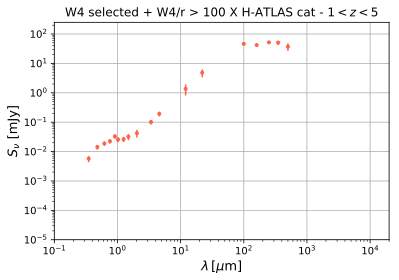

In [154]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.errorbar(3.4, W1_100, yerr=errW1_100, fmt='o', color='tomato', ms=3)#, label='SDSS 022052.11+013711.1')
ax1.errorbar(4.6, W2_100, yerr=errW2_100, fmt='o', color='tomato', ms=3)
ax1.errorbar(12,  W3_100, yerr=errW3_100, fmt='o', color='tomato', ms=3)
ax1.errorbar(22,  W4_100, yerr=errW4_100, fmt='o', color='tomato', ms=3)
ax1.errorbar(1.02, y_100, yerr=erry_100, fmt='o', color='tomato',ms=3)#, label='UKIDSS')
ax1.errorbar(1.25, j_100, yerr=errj_100, fmt='o', color='tomato',ms=3)
ax1.errorbar(1.49, h_100, yerr=errh_100, fmt='o', color='tomato',ms=3)
ax1.errorbar(2.03, k_100, yerr=errk_100, fmt='o', color='tomato',ms=3)
ax1.errorbar(0.35, uflux_100, yerr=erruflux_100, fmt='o', color='tomato',ms=3)#, label='SDSS')
ax1.errorbar(0.48, gflux_100, yerr=errgflux_100, fmt='o', color='tomato',ms=3)
ax1.errorbar(0.62, rflux_100, yerr=errrflux_100, fmt='o', color='tomato',ms=3)
ax1.errorbar(0.76, iflux_100, yerr=erriflux_100, fmt='o', color='tomato',ms=3)
ax1.errorbar(0.91, zflux_100, yerr=errzflux_100, fmt='o', color='tomato',ms=3)

ax1.errorbar(100, GetMeanStdPACS(hatlas_cat[1].data.F100BEST[overlap_hatlas_100]*1000)[0], yerr=errflux100, fmt='o', color='tomato',ms=3)
ax1.errorbar(160, GetMeanStdPACS(hatlas_cat[1].data.F160BEST[overlap_hatlas_100]*1000)[0], yerr=errflux160, fmt='o', color='tomato',ms=3)
ax1.errorbar(250, flux250_100, yerr=errflux250_100, fmt='o', color='tomato',ms=3)
ax1.errorbar(350, flux350_100, yerr=errflux350_100, fmt='o', color='tomato',ms=3)
ax1.errorbar(500, flux500_100, yerr=errflux500_100, fmt='o', color='tomato',ms=3)

# plt.errorbar(a[:,0],a[:,1],yerr=[a[:,2],a[:,3]], fmt='x', ms=3, label=r'W4 selected $2.5<z<5$')
ax1.set_xlabel(r'$\lambda \, [\mu$m]', size=13)
ax1.set_ylabel(r'$S_{\nu}$ [mJy]', size=13)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(loc='lower left', frameon=0)
ax1.set_ylim([1e-5,2.5e2]) 
# ax1.set_ylim(1e-5) 
ax1.set_xlim([1e-1,2e4]) 
plt.grid()
plt.title(r'W4 selected + W4/r > 100 X H-ATLAS cat - $1 < z < 5$')
# plt.title(r'W4 selected X H-ATLAS cat - No $z$-cut')
plt.savefig('QSO_W4selected_W4_over_r_100_crossmatch_HATLAS_cat_1_z_5_.pdf')

In [155]:
len(overlap_hatlas_100)

7

In [161]:
lambdas = np.asarray([22, 12, 4.6, 3.4, 2.03, 1.49, 1.25, 1.02, 0.91, 0.76, 0.62, 0.48, 0.35, 100, 160, 250, 350, 500])#, 1100])


In [162]:
fluxes_mean_100 = np.asarray([W4_100,W3_100,W2_100,W1_100,k_100,h_100,j_100,y_100,zflux_100,iflux_100,rflux_100,gflux_100,uflux_100,GetMeanStdPACS(hatlas_cat[1].data.F100BEST[overlap_hatlas_100]*1000)[0], GetMeanStdPACS(hatlas_cat[1].data.F160BEST[overlap_hatlas_100]*1000)[0], flux250_100, flux350_100, flux500_100])

0.333333333333
0.285714285714


In [163]:
errs_100 = np.asarray([errW4_100,errW3_100,errW2_100,errW1_100,errk_100,errh_100,errj_100, erry_100, errzflux_100,erriflux_100,errrflux_100,errgflux_100, errgflux_100, np.nan, np.nan, errflux250_100, errflux350_100, errflux500_100])

In [164]:
np.savetxt('SED_W4_selected_W_over_r_100_cross_match_HATLAS_cat_1_z_5.dat', np.c_[lambdas, fluxes_mean_100, errs_100, errs_100], header='SED of W4 selected objects with W4/r > 100 and counterpart in H-ATLAS catalog \n columns are lambda [micron], flux [mJy]  1sigma_err_low [mJy] 1sigma_err_high [mJy]')